# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding Project** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
import pickle
%matplotlib inline

## Camera Calibration

Goal: calibrate a camera to get rid of distortion on the image.
Approach: Take pictures of the known shpaes --> this will help us identify the distorted areas of hte picture. 
Any regular+hight contrast pattern could be used - we will use checkboard as one of the most common ones.
Create a transform that maps distorted points to unditorted points

* ### Step 0: 
Load images used for calibration:




This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


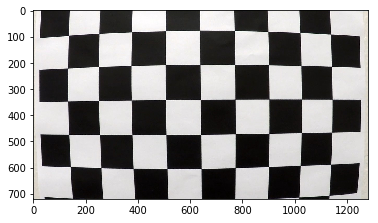

In [2]:
#reading in an image
image = mpimg.imread('camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

* ### Step 1: 
Map the coordinates of the corners of the 2D-calibration image [Image Points] to the 3D-coordinates of the real undistorted chessboard corners [Object Points]

    Prepare 2 arrays to store `Image-Points` and `Object-Points`



In [3]:
# Create 2 arrays to store Image-Points and Object-Points
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

# prepare object points:  (2,0,0), (1,4,0) ....,(6,5,0)  
# 0 in pos 3 means Z-coordinate is set to 0 - all points in 1 plane
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  # fill x, y coordinates

* ### Step 2: 
Convert image to grayscale and apply `cv.findChessboardCorners()` function, that returns the corners coordinate from a calibration image. Assign this corners coordinates to `Image Points`

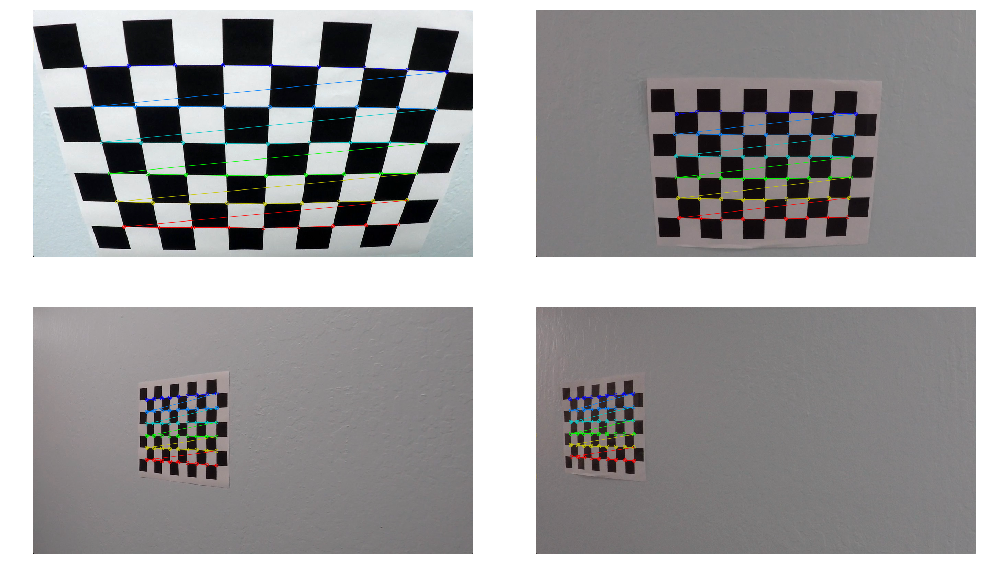

In [4]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(2,2, figsize=(18, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
plot_count=0

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found,add imgpoints and draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #print (i, '  ',(i%6) ,'  ', plot_count)
        if (i % 5)==1:
        # Draw every 5th succesfull and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            axs[plot_count].axis('off')
            axs[plot_count].imshow(img)
            plot_count=plot_count+1

* ### Step 3: 
Calibrate camera using precalculated `Image Points` and `Object Points`

In [5]:
# Test undistortion on an image
calibration_img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (calibration_img.shape[1], calibration_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist_cal_img = cv2.undistort(calibration_img, mtx, dist, None, mtx)

#plt.imshow(undist)

(-0.5, 1279.5, 719.5, -0.5)

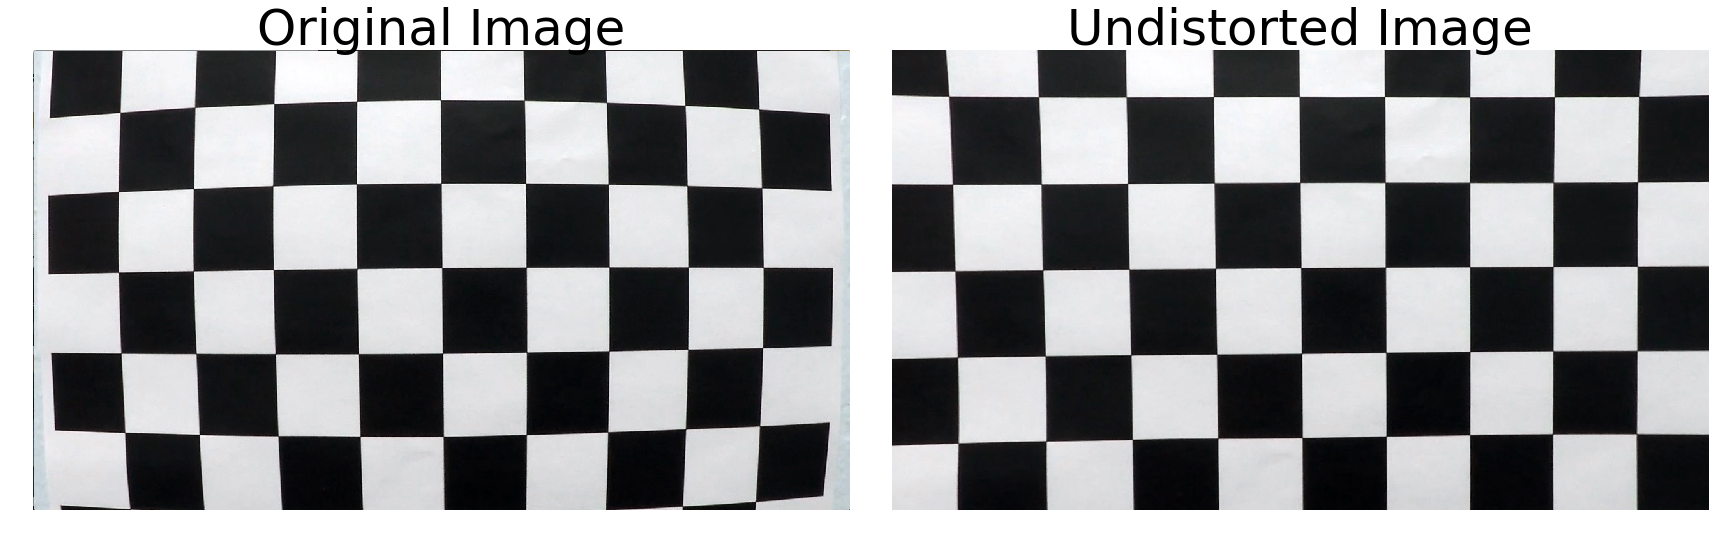

In [6]:
# Visualize results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibration_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_cal_img)
ax2.set_title('Undistorted Image', fontsize=50)
ax1.axis('off')
ax2.axis('off')


* ### Step 4: 
Demonstrate Distortion removal on the Road conditions raw image:

Text(0.5,1,'Undistorted Image')

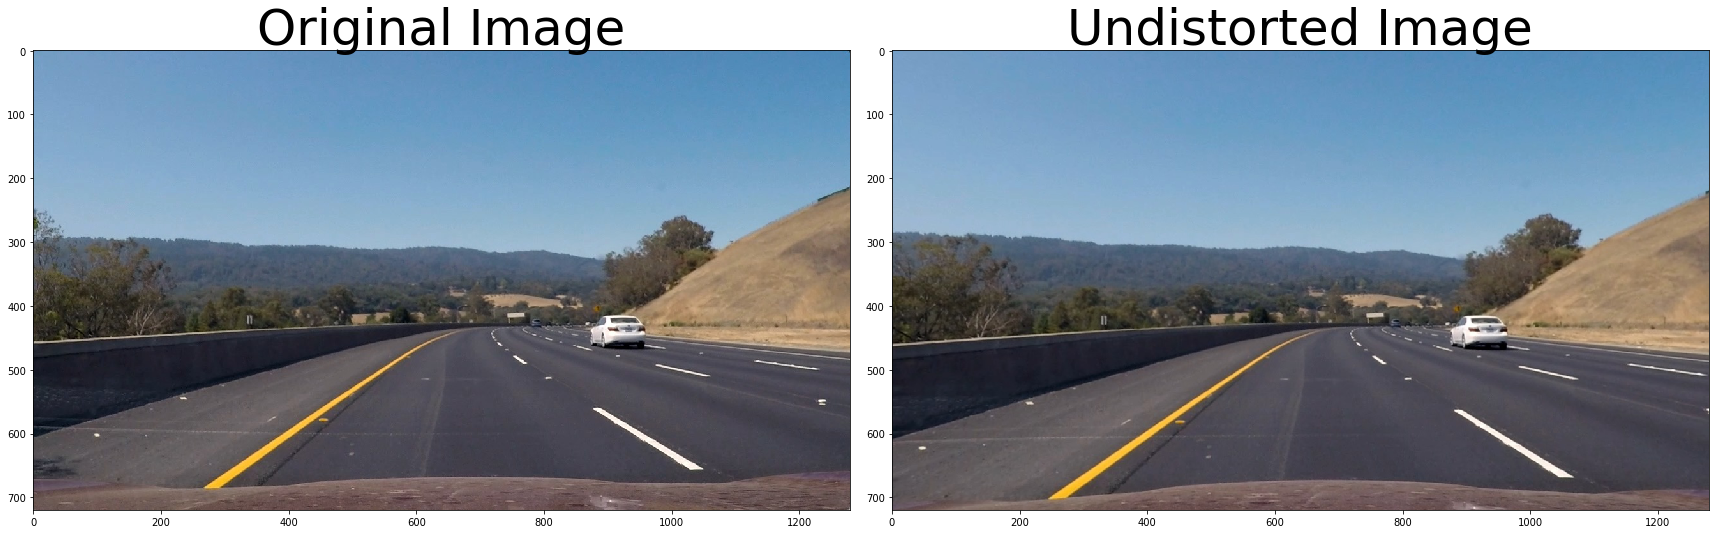

In [7]:
# Test undistortion on an image
raw_test_img = cv2.imread('./test_images/test3.jpg')
raw_test_img = cv2.cvtColor(raw_test_img, cv2.COLOR_BGR2RGB)

undist_raw_test = cv2.undistort(raw_test_img, mtx, dist, None, mtx)

# Visualize results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_raw_test)
ax2.set_title('Undistorted Image', fontsize=50)

## Perspective Transform



Goal: map the points in a given image to different, desired, image points with a new perspective. 
Approach: make a "bird’s-eye" view transform that will let us view a lane from above; 

* ### Step 0: 
Define `warp()` function that will perform a `Perspective transform` for a desired image:




In [8]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspecitve transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # create warped image - use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

* ### Step 1: 
Define desired plane for Perspective transform setting up 4 points on the test image `src`

Text(0.5,1,'Undistorted Image with ROI')

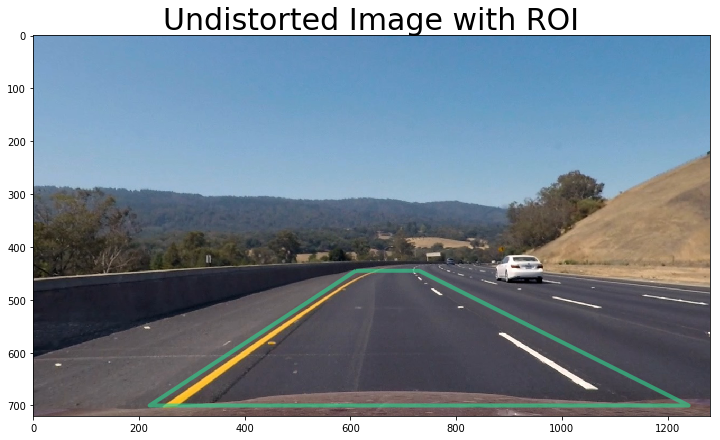

In [9]:
prewarp_img = undist_raw_test

fig, axs = plt.subplots(figsize=(14, 7))
axs.imshow(prewarp_img)

src = np.float32(
    [(610,445),
     (730,445), 
     (220,700), 
     (1240,700)])

x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
axs.plot(x, y, color='#33cc8c', alpha=0.65, linewidth=4, solid_capstyle='butt', zorder=2)
axs.set_title('Undistorted Image with ROI', fontsize=30)

* ### Step 2: 
Perform `Perspective Transform`

Text(0.5,1,'Unwarped Image')

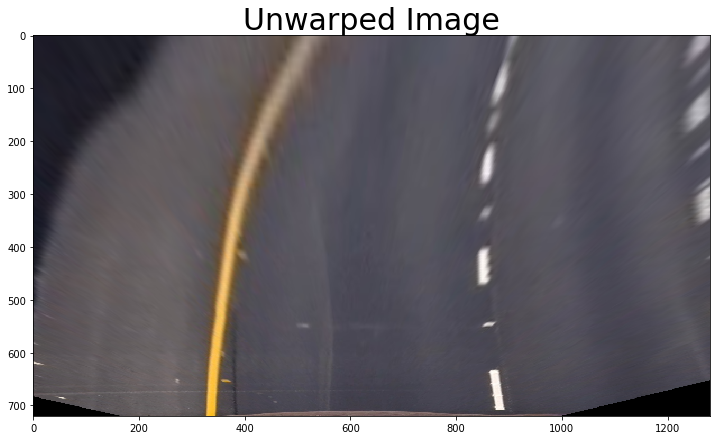

In [10]:
#dst = np.float32([(220,0),
#                  (980,0),
#                  (220,720),
#                  (980,720)])
dst = np.float32([(310,0),
                  (prewarp_img.shape[1]-310,0),
                  (310,prewarp_img.shape[0]),
                  (prewarp_img.shape[1]-310,prewarp_img.shape[0])])




warp_test_img, M, Minv = warp(prewarp_img, src, dst)

fig, axs2 = plt.subplots(figsize=(14, 7))
axs2.imshow(warp_test_img)
axs2.set_title('Unwarped Image', fontsize=30)


## Color and Directional Gradient Transform



Goal: use gradients in a smarter way to detect steep edges that are more likely to be lanes - take individual derivatives/gradient along 1 directio X or Y. 


* ### Step 1: Sobel Threshold
Goal is to identify pixels where the gradient of an image falls within a specified threshold range.

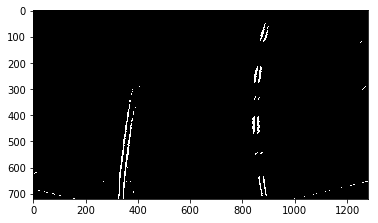

In [11]:
def abs_sobel_thresh(img, orient='x', thresh_min=33, thresh_max=222):
    #-1- Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #-2-Apply x or y gradient with the OpenCV Sobel() function
    #-3-and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    #-4-Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #-5-Create a copy 
    binary_output = np.zeros_like(scaled_sobel)
    #-6- Apply the threshold
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1

    # Return the result
    return binary_output

plt.imshow(abs_sobel_thresh(warp_test_img, orient='x'),cmap='gray')

* ### Step 2: HLS L-channel threshold
Exploit S channel of the HLS - according to lesson provided information, works best to detect lines under varying lightning conditions

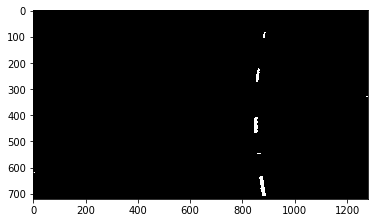

In [12]:
def L_select(img, thresh=(205, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    if np.max(l_channel) > 125:
        #lab_b = lab_b*(255/np.max(lab_b))
        l_channel = l_channel*(255/np.max(l_channel))
    
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

plt.imshow(L_select(warp_test_img),cmap='gray')

* ### Step 3: Lab channel threschold

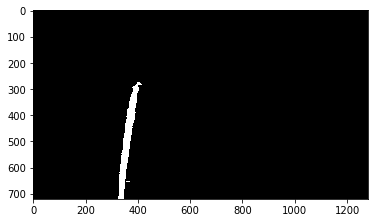

In [13]:
def lab_B(img, sobel_kernel=1, thresh=(191, 255)):
    # LAB space convert
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    # select B channel
    lab_b = lab[:,:,2]
    # Take the absolute value of the gradient direction, 
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
            
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1

    # Return the binary image
    return binary_output

plt.imshow(lab_B(warp_test_img),cmap='gray')

* ### Step 4: Sobel Magnitude Threshold

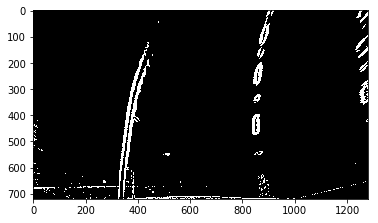

In [14]:
def mag_thresh(img, sobel_kernel=17, mag_thresh=(33, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #-1-Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    #-2- Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    #print (np.max(gradmag))
    #-3-Rescale to 8 bit
    #scale_factor = np.max(gradmag)/255 
    gradmag_scaled = np.uint8(255*gradmag)/np.max(gradmag) 
    
    #-4-Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

plt.imshow(mag_thresh(warp_test_img),cmap='gray')

### Visualisation of Color and Direction transform

(-0.5, 1279.5, 719.5, -0.5)

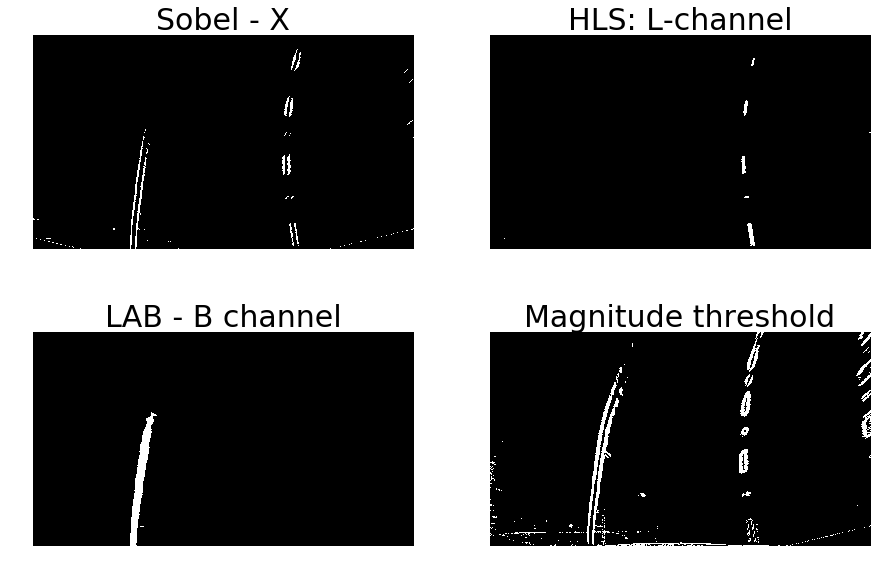

In [15]:
f, axes= plt.subplots(2,2,figsize=(15,10))
#f.subplots_adjust(hspace=0.05)

#warp_test_img

axes[0,0].imshow(abs_sobel_thresh(warp_test_img, orient='x'),cmap='gray')
axes[0,0].set_title("Sobel - X", fontsize=30)
axes[0,0].axis('off')

axes[0,1].imshow(L_select(warp_test_img),cmap='gray')
axes[0,1].set_title("HLS: L-channel", fontsize=30)
axes[0,1].axis('off')

axes[1,0].imshow(lab_B(warp_test_img),cmap='gray')
axes[1,0].set_title("LAB - B channel", fontsize=30)
axes[1,0].axis('off')

axes[1,1].imshow(mag_thresh(warp_test_img),cmap='gray')
axes[1,1].set_title("Magnitude threshold", fontsize=30)
axes[1,1].axis('off')

### Defining combination of the threscholds

In [16]:
def comb_threshold (img):
    img_sx=abs_sobel_thresh(img, orient='x')
    img_L=L_select(img)
    img_B=lab_B(img)
    img_mag=mag_thresh(img)

    combined = np.zeros_like(img_sx)
    combined[((img_B==1)) | ((img_L==1))] = 1
    return combined


Text(0.5,1,'Combined threshold')

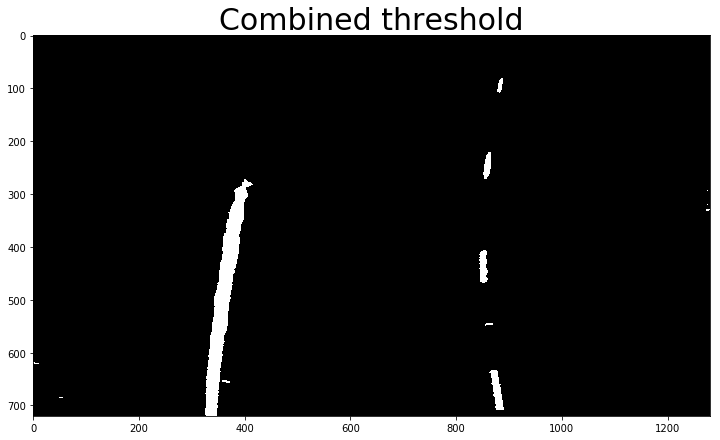

In [17]:
# Visualize comb_threshold
comb_binary=comb_threshold(warp_test_img)
fig, axs2 = plt.subplots(figsize=(14, 7))
axs2.imshow(comb_binary,cmap='gray')
axs2.set_title('Combined threshold', fontsize=30)

### Histogram calculation for Warped Image

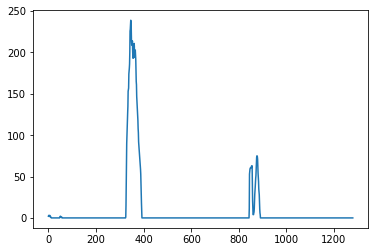

In [18]:
def Hist_calc(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)


plothist = Hist_calc(comb_threshold(warp_test_img))

f, ax = plt.subplots(1,1)

ax.plot(plothist)

### Test pipeline with test images

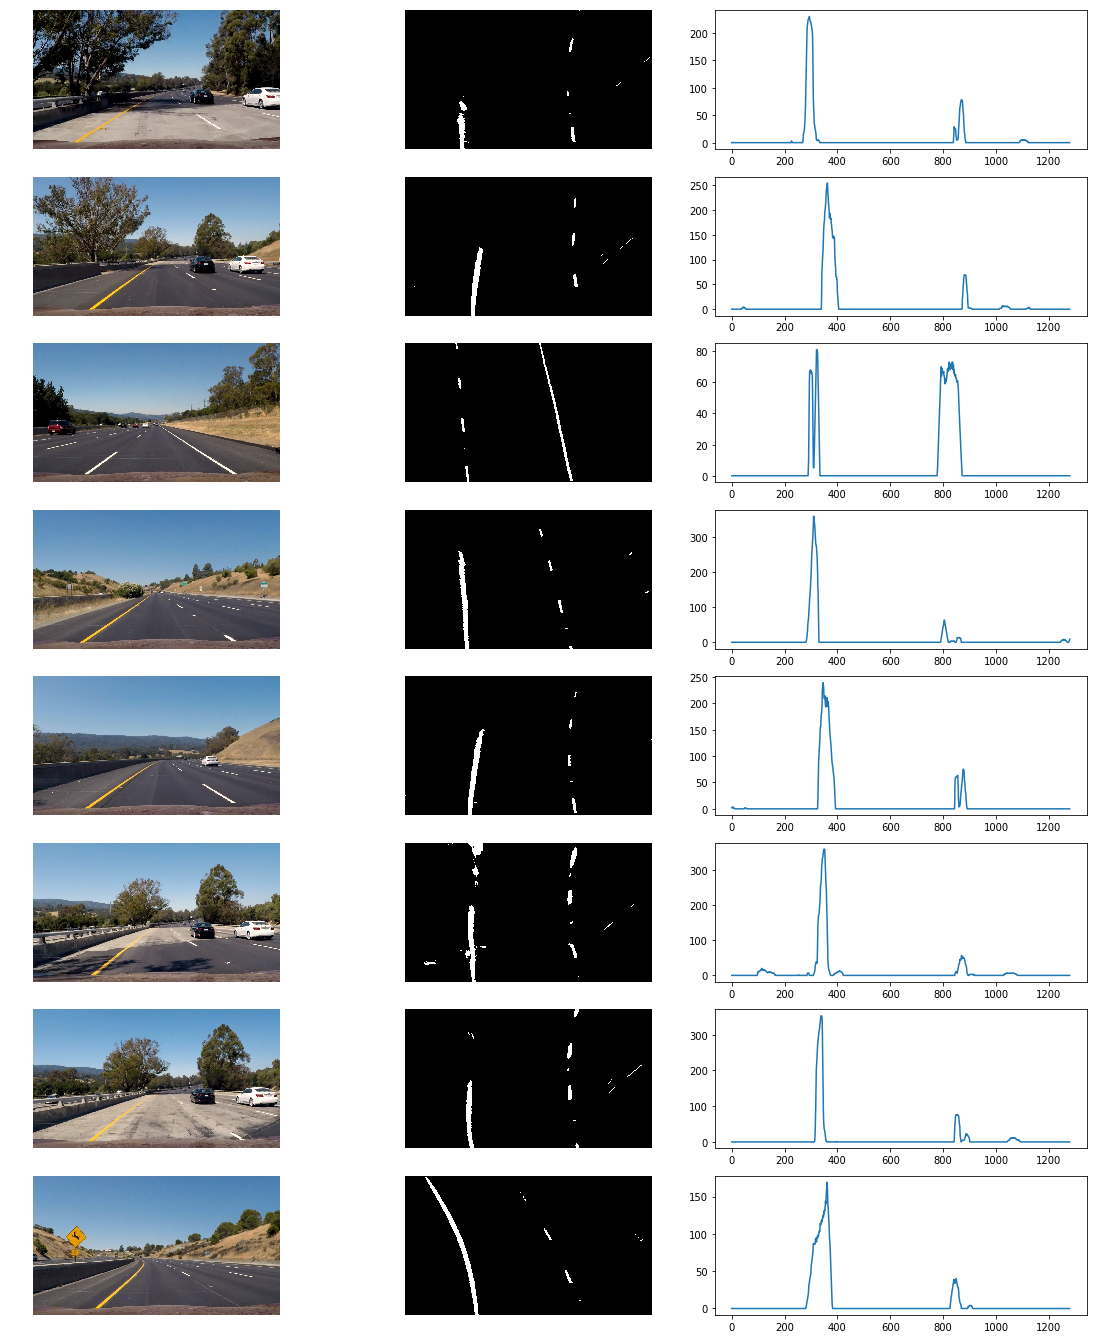

In [19]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')


# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(20, 24))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    warp_img, M, Minv = warp(undist_img, src, dst)
    img_bin = comb_threshold(warp_img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].plot(Hist_calc(img_bin))
    i += 1

### Full pipeline

In [20]:
def image_pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warp_img, M, Minv = warp(undist, src, dst)
    comb_binary=comb_threshold(warp_img)
    return comb_binary, Minv

### Sliding window Step

In [41]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 22

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        pass
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

In [42]:
def Visualize_Sliding_Window(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ### Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    plt.figure(figsize=(18,12))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

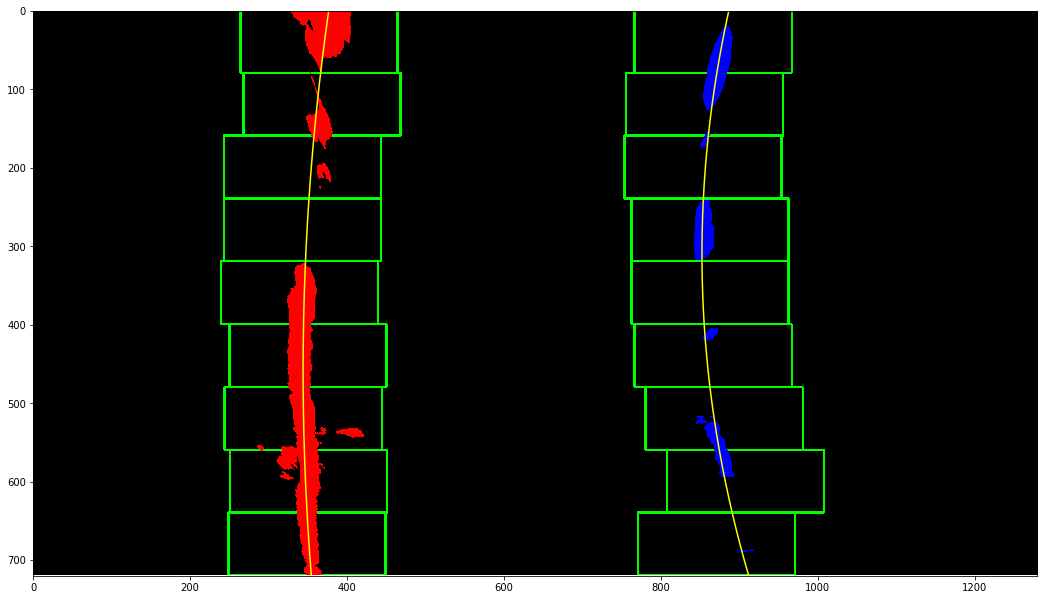

In [43]:
# Draw Sliding Window Visualization
exampleImg = cv2.imread('./test_images/test4.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = image_pipeline(exampleImg)


l_fit,r_fit,ld,rd,out_img=find_lane_pixels(exampleImg_bin)
Visualize_Sliding_Window(exampleImg_bin,l_fit,r_fit,ld,rd,out_img)

* ### Step 4: Sobel Magnitude Threshold

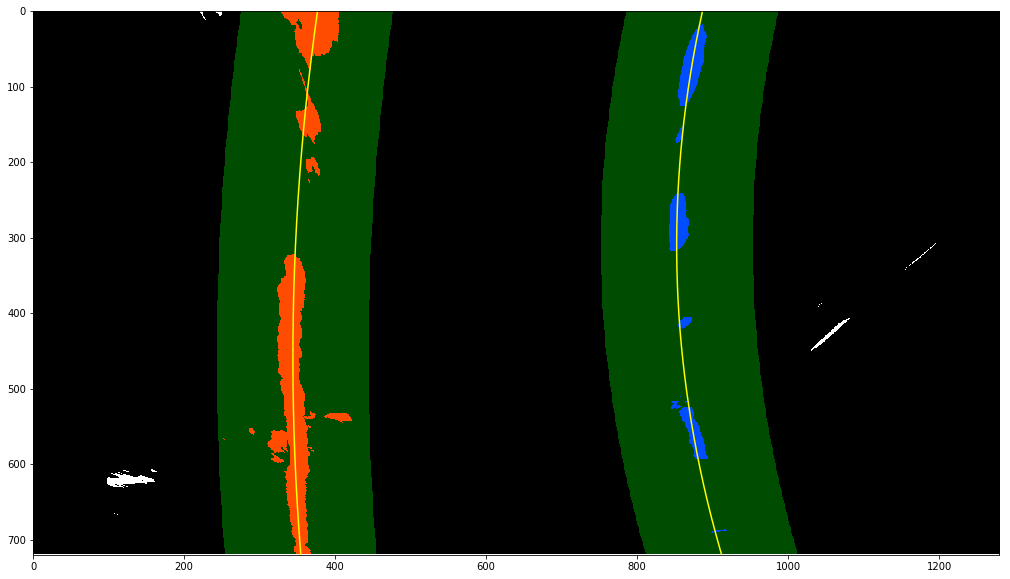

In [24]:
def Visualize_Lane_Detection(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
     
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l_fit,r_fit,ld,rd,out_fit=find_lane_pixels(exampleImg_bin)
Visualize_Lane_Detection(exampleImg_bin,l_fit,r_fit,ld,rd,out_fit)

In [25]:
def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
 
    # to cover same y-range as image
    ploty = np.linspace(0, h-1, num=h)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

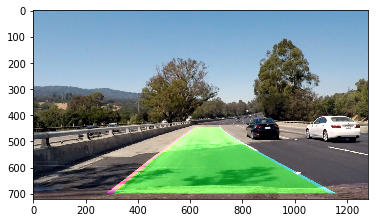

In [26]:
#Test line drawing algorithm
lane_pixels =  find_lane_pixels(exampleImg_bin)
left_fit=lane_pixels[0]
right_fit=lane_pixels[1]
finalImage=DrawLine(exampleImg,exampleImg_bin,left_fit,right_fit)
plt.imshow(finalImage)

### Calculate radius of curvature

In [27]:
def calc_ROC(binary_warped,left_fit,right_fit):
    #assume values suggested in classroom
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Calc both polynomials using ploty, left_fit and right_fit ###
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Car position estimated to be in the middle of the picture
    car_position= binary_warped.shape[1]/2
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval=np.max(ploty)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    distance_to_center= (car_position - actualPosition)* 0.2*xm_per_pix
    
    # Now our radius of curvature is in meters
    
    return (left_curverad + right_curverad)/2, distance_to_center

In [47]:
from random import randint
import datetime
import time
def pipeline(originalImage):
    
    undist = cv2.undistort(originalImage, mtx, dist, None, mtx)
    warp_img, M, Minv = warp(undist, src, dst)
    combinedImage=comb_threshold(warp_img)
    lane_pixels =  find_lane_pixels(combinedImage)
    left_fit=lane_pixels[0]
    right_fit=lane_pixels[1]

    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
    
    radius, distance = calc_ROC(combinedImage,left_fit,right_fit)
    cv2.rectangle(finalImage, (25,25),(1150,200),(80,80,80), -1)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (50,100), 1, 4, (0,255,0),5)
    cv2.putText(finalImage,"Distance from center is {:.2f}".format(distance)+ "m", (50,150), 1, 4, (0,255,0),5)
            
    #cv2.imwrite('./Output_1/'+str(st)+'.jpg',originalImage)
    cv2.imwrite('./Output_1/'+'_out.jpg',finalImage)
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))

    return finalImage

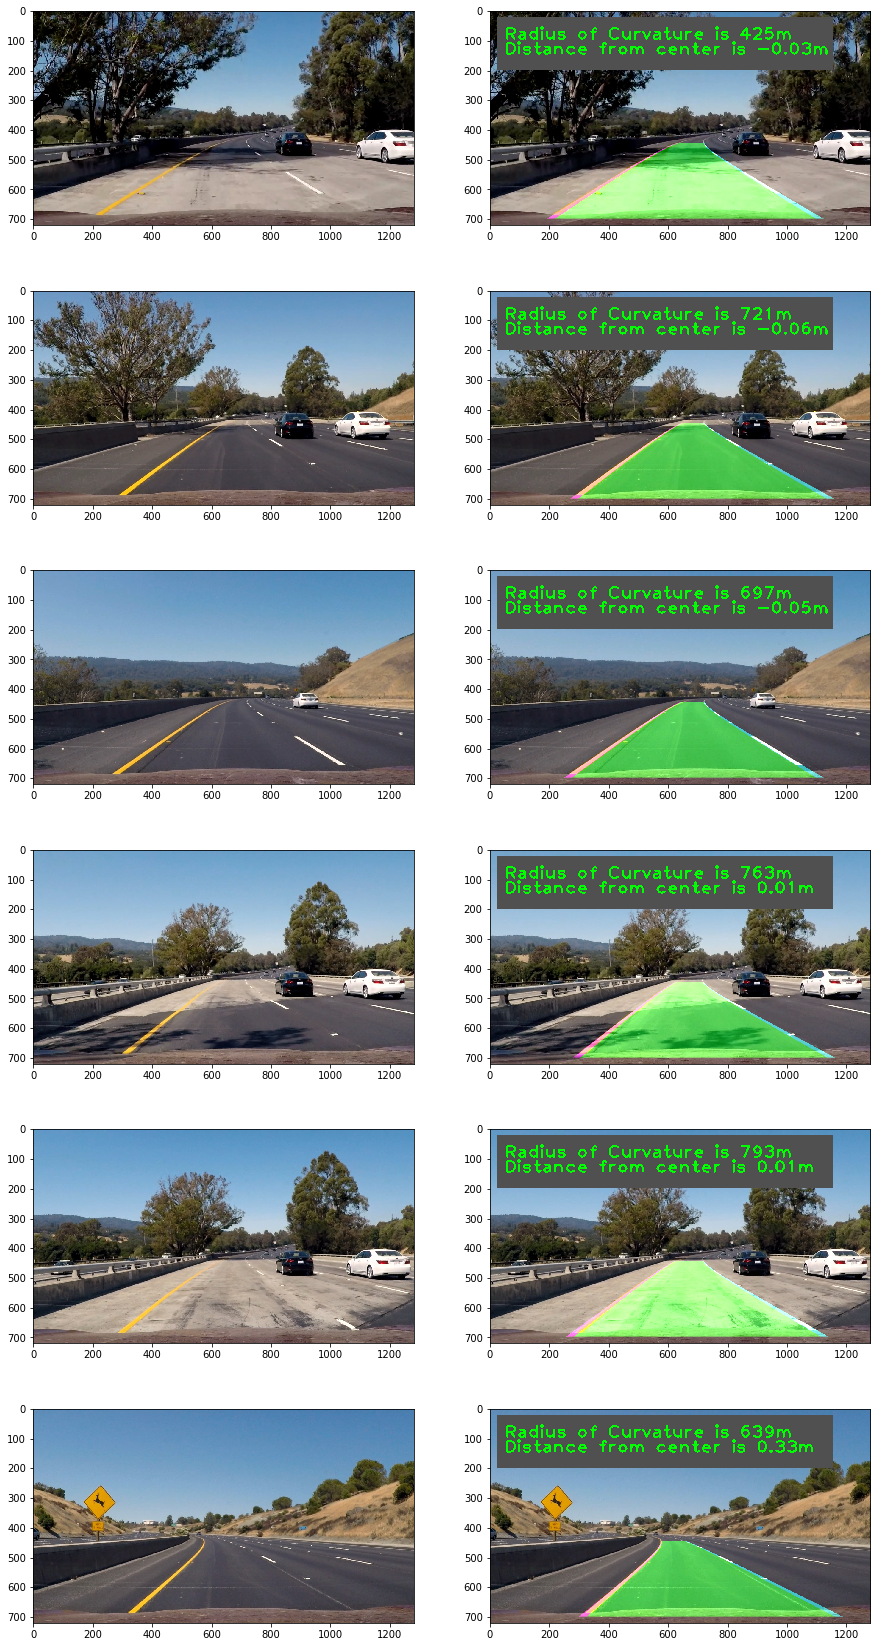

In [48]:
#Test pipeline  on test images
f, axes= plt.subplots(6,2,figsize=(15,30))
images = glob.glob('test_images/test*.jpg') # Reading Images from test_images folder

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    #originalImage= cv2.imread(image)
    finalImage=pipeline(originalImage)
    cv2.imwrite('output_images/'+str(index)+'.jpg', cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB))
    axes[index,0].imshow(originalImage)
    axes[index,1].imshow(finalImage)

## Running pipeline on Video

In [30]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:16<00:00,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 42s, sys: 41.3 s, total: 3min 24s
Wall time: 5min 19s


In [31]:
from IPython.display import HTML
HTML("""
<video width="640" height="310" controls>
  <source src="{0}">
</video>
""".format(video_output1))